In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import h, m_e, M_sun, c
from agnpy.emission_regions import Blob
from agnpy.targets import SSDisk, SphericalShellBLR, RingDustTorus
from agnpy.absorption import Absorption, sigma
from agnpy.compton import cos_psi
import matplotlib.pyplot as plt

In [2]:
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
# equivalency to transform frequencies to energies in electron rest mass units
epsilon_equivalency = [
    (u.Hz, u.Unit(""), lambda x: h.cgs * x / mec2, lambda x: x * mec2 / h.cgs)
]

In [3]:
# define the blob
spectrum_norm = 1e47 * u.erg
parameters = {"p": 2.8, "gamma_min": 10, "gamma_max": 1e6}
spectrum_dict = {"type": "PowerLaw", "parameters": parameters}
R_b = 1e16 * u.cm
B = 0.56 * u.G
z = 0
delta_D = 40
Gamma = 40
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

In [4]:
# disk parameters
M_BH = 1.2 * 1e9 * M_sun.cgs
L_disk = 2 * 1e46 * u.Unit("erg s-1")
eta = 1 / 12
R_in = 6
R_out = 200
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out, R_g_units=True)

In [5]:
# consider a fixed distance of the blob from the target fields
r = 1.1e16 * u.cm

absorption_disk = Absorption(blob, disk, r=r)

# array of distances
l_max = 3000 * u.pc
l = np.logspace(
    np.log10(r.to_value("cm")),
    np.log10(l_max.to_value("cm")),
    10
) * u.cm

# array of phi
phi = np.linspace(0, 2 * np.pi, 50)

In [10]:
def tau_disk(nu):
    # define the dimensionless energy
    epsilon_1 = nu.to("", equivalencies=epsilon_equivalency)
    # transform to BH frame
    epsilon_1 *= 1 + blob.z
    # each value of l, distance from the BH, defines a different range of
    # cosine integration, we have to break the integration as the array of
    # mu takes different values at each distance
    integral = np.empty(len(epsilon_1))
    for j, _epsilon_1 in enumerate(epsilon_1):
        integrand_l = np.empty(len(l))
        for i, _l in enumerate(l):
            l_tilde = (_l / disk.R_g).to_value("")
            # for the multidimensional integration on the angles only
            # axis 0 : phi
            # axis 1 : mu
            _phi = np.reshape(phi, (1, phi.size))
            mu = disk.mu_from_r_tilde(l_tilde)
            _mu = np.reshape(mu, (mu.size, 1))
            _cos_psi = cos_psi(blob.mu_s, _mu, _phi)
            _epsilon = disk.epsilon_mu(_mu, l_tilde)
            _phi_disk_mu = disk.phi_disk_mu(_mu, l_tilde)
            _s = _epsilon_1 * _epsilon * (1 - _cos_psi) / 2
            _integrand_mu = _phi_disk_mu / (
                _epsilon
                * np.power(_l, 3)
                * _mu
                * np.power(np.power(_mu, -2) - 1, 3 / 2)
            )
            _integrand = _integrand_mu * (1 - _cos_psi) * sigma(_s)
            # integrate over mu and phi
            integral_mu = np.trapz(_integrand, mu, axis=0)
            integral_phi = np.trapz(integral_mu, phi, axis=0)
            integrand_l[i] = integral_phi.to_value("cm-1")
        # integrate over l
        integral[j] = np.trapz(integrand_l, l, axis=0).to_value("cm")

    prefactor_num = 3 * disk.L_disk * disk.R_g
    prefactor_denum = 16 * np.pi**2 * disk.eta * m_e * np.power(c, 3)
    return prefactor_num / prefactor_denum * integral

In [11]:
# array of sampled taus
sampled_tau = np.loadtxt(
    f"agnpy/tests/sampled_taus/tau_disk_figure_14_finke_2016.txt", delimiter=",", comments="#",
)
E_ref = sampled_tau[:, 0] * u.GeV
tau_ref = sampled_tau[:, 1] 

In [12]:
# compute our own tau
E = np.logspace(0, 5) * u.GeV
nu = E.to("Hz", equivalencies=u.spectral())
tau = tau_disk(nu)

/home/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


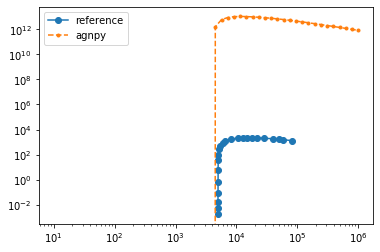

In [16]:
plt.loglog(E_ref, tau_ref, ls="-", marker="o", label="reference")
plt.loglog(E * 10, tau, ls="--", marker=".", label="agnpy")
plt.legend()

In [17]:
disk.mu_from_r_tilde(l)

UnitConversionError: Can only apply 'add' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)